# Compute the Structure Factor and Boson Entropy from the Pair Correlation Function After a Quench

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi as π

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from collections import defaultdict
import pickle

import include.colors as colortools

### Load useful utilities from disk

In [2]:
import quenchutils as quench

## Load ED data from disk and compute the pair correlation function

Using the notation in Appendix A4 in Giuliani and Vignale "Quantum Theory of the Electron Liquid" on Page 682 Eq. (A4.2) we define:

\begin{equation}
g_2(i-j) = \frac{\langle \hat{n}_i \hat{n}_j \rangle}{\rho_0^2} - \frac{\delta_{i,j}}{\rho_0}
\end{equation}

where $\rho_0$  is the density.

In [3]:
g2,g2_eq = {},{}

Vi = 0.0
Vf = [-0.5,-0.25,-0.15,0.15,0.25,0.765]
Δt = 0.1
ti = 0.0
ρ = 0.5  # 1/2 filling in units where the lattice spacing is unity
kF = π*ρ # Fermi wavevector

N = np.arange(4,14)
cn = 1
bc = 'PBC'
colors = colortools.get_linear_colors('Spectral',len(Vf),reverse=False)

# Get Equilbrium Results First
ti,tf = 0.0,0.0
for cVf in Vf:
    Vi = cVf
    for i,cN in enumerate(N):
        data_dir = '../data/equilibrium/'
        try:
            p_data = np.loadtxt(quench.get_ED_fname(cN,Vi,cVf,Δt,ti,tf,cn,data_dir,fmt='g2'))
            key = quench.lookup(cN,Vi,cVf,Δt,cn,bc=bc)
            g2_eq[key] = p_data[1:]
            g2_eq[key] /= ρ**2
            g2_eq[key][0] -= 1/ρ
        except:
            print("Can't load: {:s}".format(quench.get_ED_fname(cN,Vi,cVf,Δt,ti,tf,cn,data_dir,fmt='g2')))

# Load the quench results from disk
Vi = 0.0
ti,tf = 0.0,100.0
for cVf in Vf:
    for i,cN in enumerate(N):
        data_dir = f'../data/quench/ED/{bc:s}/'
        try:
            p_data = np.loadtxt(quench.get_ED_fname(cN,Vi,cVf,Δt,ti,tf,cn,data_dir,fmt='g2'))
            key = quench.lookup(cN,Vi,cVf,Δt,cn,bc=bc)
            g2[key] = p_data
            g2[key][:,1:] /= ρ**2
            g2[key][:,1] = g2[key][:,1] - 1/ρ
        except:
            print("Can't load: {:s}".format(quench.get_ED_fname(cN,Vi,cVf,Δt,ti,tf,cn,data_dir,fmt='g2')))

## The Structure Factor

In order to obtain the Fourier components of the density fluctuation operator we express things in terms of the static structure factor $s(q)$ defined by:

\begin{equation}
S(q;t) = 1 + f\sum_{x=0}^{L/2-1} \left[g_2(x;t)-1 \right] \mathrm{e}^{-i q x}
\end{equation}

where $f = \rho_0 a_0$ is the filling fraction with $a_0$ the lattice spacing (set to unity here).  

Let us investigate it's time dependence re-scaled by the ground state LL prediction $S_{LL}(q) = K \frac{|q|}{2k_{\rm F}}$ where we evaluate the Luttinger paramger $K$ via the Bethe ansatz 

\begin{equation}
K = \frac{\pi}{2\cos^{-1}(-V/2J)}
\end{equation}




In [4]:
S_eq = {}
q = {}
n_eq = {}

for iV,cVf in enumerate(Vf):
    for cN in N:
        key_eq = quench.lookup(cN,cVf,cVf,Δt,cn)

        # Equilibrium Structure factor
        S_eq[key_eq] = (1.0 + ρ*np.fft.rfft(g2_eq[key_eq]-1)).real
        S_eq[key_eq][0] = 1E-16

In [5]:
S̄ = defaultdict(list)
q = {}

for iV,cVf in enumerate(Vf):
    K = quench.KV(cVf)
    
    for cN in N:
        key = quench.lookup(cN,Vi,cVf,Δt,cn)
        key_eq = quench.lookup(cN,cVf,cVf,Δt,cn)
        
        if key in g2:

            x = np.arange(2*cN)
            Δx = x[1]-x[0]
            q[key] = 2*π*np.fft.rfftfreq(x.size,Δx)
            q[key][0] = 1E-16
            
            SLL = K*np.abs(q[key])/(2.0*kF) 
            SLL = S_eq[key_eq]
        
            len_t = len(g2[key][:,0])
            for it in range(len_t):
                S̄[key].append((1.0 + ρ*np.fft.rfft(g2[key][it,1:]-1.0).real)/SLL)
                
            S̄[key] = np.array(S̄[key])

## Extracting the boson momentum distribution at low-$q$

We want to investigate fitting the time dependence of the low-q structure factor to the Luttinger liquid prediction:

\begin{equation}
\bar{s}(q; t) \equiv \frac{s(q; t)}{K |q|/(2k_{\rm F})}  =    2 n(q) + 1 + \cos(2 \omega_q t) \sinh(2 \beta) 
\end{equation}

and we will perform a 3 paramter fit to $n_{\rm LL}$, $C$ and $\omega_q$ via

\begin{equation}
\bar{s}(q; t) = 1 + 2 n_{\rm LL} + C \cos(2 \omega_q t)\; .
\end{equation}

In [9]:
from lmfit import minimize, Parameters

def get_fit(x,y,nLL,C,ω):
    fit_params = Parameters()
    fit_params.add('nLL', value=nLL, min=0.0, max=1.0, vary=True)
    fit_params.add('C', value=C, min=-1.0, max=1.0, vary=True)
    fit_params.add('c1',value=0.0, vary=False)
    fit_params.add('omega', value=ω, min=0.0, vary=True)

    def f(params,x_):
        p = {}
        [p.update({pname:params[pname].value}) for pname in ['nLL','C','c1','omega']]
        return 1.0 + 2*p['nLL'] + p['c1']*x_ + p['C']*np.cos(2*p['omega']*x_)
        
    def fss_residual(params, x_, y_):
        return f(params,x_) - y_
    
    fit = minimize(fss_residual, fit_params, args=(x,y))    
    
    return lambda x: f(fit.params,x),fit

def S̄LL(params,x_):
    p = {}
    [p.update({pname:params[pname].value}) for pname in ['nLL','C','c1','omega']]
    return 1.0 + 2*p['nLL'] + p['c1']*x_ + p['C']*np.cos(2*p['omega']*x_)

In [7]:
Sfit,ΔSfit = {},{} 

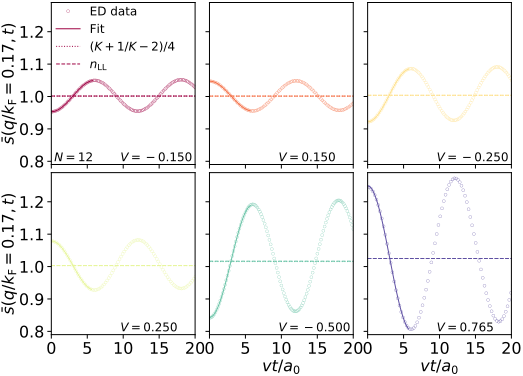

In [54]:
with plt.style.context('./include/notebook.mplstyle'):

    fig, axes = plt.subplots(2,3,sharex=True, sharey=True, squeeze=True, figsize=(8,6))
    axes = axes.flatten()
    fig.subplots_adjust(hspace=0.05, wspace=0.1)

    cN = N[-2]
    q_index = 1

    Vp = [-0.15,0.15,-0.25,0.25,-0.5,0.765]
    for iV,cVf in enumerate(Vp):

        key = quench.lookup(cN,Vi,cVf,Δt,cn)
        K = quench.KV(cVf)
        if key in S̄:

            # get the time dependent n(q,t) data and perform a fit
            data = S̄[key][:,q_index]
            t = g2[key][:,0]*quench.tscalefactor(cVf)

            # find the main oscillation frequency
            #S̄_qω = np.fft.rfft(data).real
            #ω = 2*π*np.fft.rfftfreq(t.size,t[1]-t[0])
            #ω0 = ω[np.argmax(np.abs(S̄_qω[1:]))+1]
            #ω0 = 2.0*q[key][q_index]

            # estimate parameters in the fit
            nLL0 = quench.γeq(quench.KV(cVf))**2/2
            C0 = quench.γ(quench.KV(cVf)) # 0.5*(1/K-K) 
            ω0 = q[key][q_index]

            stop_fit = np.where(np.abs(g2[key][:,0]*quench.tscalefactor(cVf)-cN/2)<Δt*quench.tscalefactor(cVf))[0][0]
            fit_n,fit = get_fit(t[:stop_fit],data[:stop_fit],nLL0,C0,ω0)

            Sfit[key] = fit #.params['nLL'].value
            ΔSfit[key] = fit # .params['nLL'].stderr

            #fit.params.pretty_print()

            props = {'mec':colors[iV],'mew':0.25, 'ls':'None','ms':3, 'mfc':'None'}
            axes[iV].plot(t,data, 'o', **props, label='ED data')
            axes[iV].plot(t[:stop_fit],S̄LL(Sfit[key].params,t[:stop_fit]),'-', color=colors[iV], linewidth=1, label=r'Fit')

            axes[iV].axhline(y=(1+2*nLL0), color=colors[iV], linewidth=1, ls=':', zorder=-10, label=r'$(K+1/K-2)/4$')
            axes[iV].axhline(y=(1+2*fit.params['nLL'].value), color=colors[iV], linewidth=1, ls='--', zorder=-1, label=r'$n_{\rm LL}$')

            if not iV % 3:
                cq = q[key][q_index]/kF
                axes[iV].set_ylabel(r'$\bar{{s}}(q/k_{{\rm F}}={:.2f},t)$'.format(cq))
            axes[iV].set_xlim(0,20)
            axes[iV].text(0.48,0.02,'$V = {:5.3f}$'.format(cVf),transform=axes[iV].transAxes, fontsize=12, ha='left')


    axes[0].text(0.02,0.02,f'$N = {cN}$',transform=axes[0].transAxes, fontsize=12, ha='left')
    axes[0].legend(loc=(0.0,0.55), fontsize=12)
    axes[-2].set_xlabel(r'$vt/a_0$')
    axes[-1].set_xlabel(r'$vt/a_0$')
    axes[-1].set_ylim(0.79,1.29)

    plt.savefig(f'../figures/nqt_vs_t_with_fit_N_{cN}.svg')

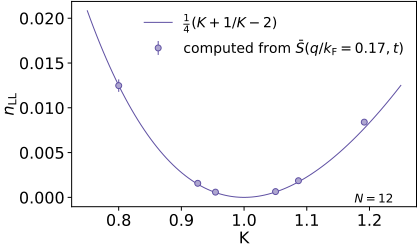

In [11]:
with plt.style.context('./include/notebook.mplstyle'):

    fit_K = np.linspace(0.75,1.25,100)

    props = {'mec':colors[-1],'mew':1.0, 'ecolor':colors[-1], 'elinewidth':1.0, 'ls':'None','ms':6,
                 'mfc':colortools.get_alpha_hex(colors[-1],0.5)}
    fig, axes = plt.subplots(1,1)

    for iV,cVf in enumerate(Vf):
        key = quench.lookup(cN,Vi,cVf,Δt,cn)
        K = quench.KV(cVf)
        n0 = 0.25*(fit_K+1/fit_K-2)
        if iV == 0:
            cq = q[key][1]/kF
            lab=r'computed from $\bar{{S}}(q/k_{{\rm F}}={:.2f},t)$'.format(cq)
        else:
            lab=''
        axes.errorbar(K,Sfit[key].params['nLL'].value,yerr=Sfit[key].params['nLL'].stderr, **props, label=lab, marker='o')



    axes.text(0.82,0.02,f'$N = {cN}$',transform=axes.transAxes, fontsize=12, ha='left')

    axes.plot(fit_K,n0, linewidth=1, label=r'$\frac{1}{4}(K+1/K-2)$', color=colors[-1])
    axes.set_xlabel('K')
    axes.set_ylabel(r'$n_{\rm LL}$')
    axes.legend()

    #plt.savefig('../figures/nq_vs_K_with_LL_N_13.svg')

## Paper Figure 5: Extrating $n(q)$ from $S(q;t)$ 
---

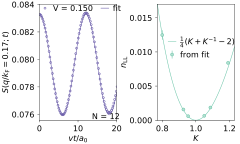

In [12]:
plt.style.reload_library()
with plt.style.context('./include/sans.mplstyle'):

    fig, axes = plt.subplots(1,2,sharex=False, sharey=False, squeeze=True)
    fig.subplots_adjust(wspace=0.525)
    cVf = 0.15
    cN = 12
    q_index = 1

    key = quench.lookup(cN,Vi,cVf,Δt,cn)
    K = quench.KV(cVf)
    
    # S(q;t) for a single value of V
    
    # get the time dependent S(q,t) data 
    data = S̄[key][:,q_index]
    t = g2[key][:,0]*quench.tscalefactor(cVf)

    props = {'mec':colors[-1],'mew':0.5, 'ls':'None','ms':2, 'mfc':'None'}
    flabel = r'fit: $1 + 2n_{\rm LL} + \sinh(2\beta)\cos(2\omega_q t)$'
    SLL = K*np.abs(q[key])/(2.0*kF)
    axes[0].plot(t,data*SLL[q_index], 'o', **props, label=f'V = {cVf:5.3f}')
    axes[0].plot(t,S̄LL(Sfit[key].params,t)*SLL[q_index],'-', color=colors[-1], linewidth=0.5, label=r'fit', zorder=-10)
    axes[0].set_xlabel(r'$vt/a_0$')
    axes[0].set_ylabel(r'$S(q/k_{{\rm F}}={:.2f};t)$'.format(q[key][q_index]/kF))
    axes[0].text(0.68,0.01,f'N = {cN}',transform=axes[0].transAxes, fontsize=8, ha='left')


    axes[0].set_xlim(0,20)
    axes[0].legend(frameon=False, loc=(-0.02,0.9), handletextpad=0.5, handlelength=1.0, ncol=2, columnspacing=1.0)
    
    # n_LL extracted from the fit vs. K
    
    fit_K = np.linspace(0.75,1.25,100)

    props = {'mec':colors[-2],'mew':0.5, 'ecolor':colors[-2], 'elinewidth':0.5, 'ls':'None','ms':3,
                 'mfc':colortools.get_alpha_hex(colors[-2],0.5)}

    for iV,cVf in enumerate(Vf):
        key = quench.lookup(cN,Vi,cVf,Δt,cn)
        K = quench.KV(cVf)
        nLL = 0.25*(fit_K+1/fit_K-2)
        if iV == 0:
            cq = q[key][q_index]/kF
            lab=f'computed from $\bar{{S}}(q/k_{{\rm F}}={cq:.2f};t)$'
            lab = 'from fit'
        else:
            lab=''
        axes[1].errorbar(K,Sfit[key].params['nLL'].value,yerr=Sfit[key].params['nLL'].stderr, **props, label=lab, marker='o')
    
    axes[1].plot(fit_K,nLL,linewidth=0.5, label=r'$\frac{1}{4}(K+K^{-1}-2)$', color=colors[-2])
        
    
    axes[1].legend(frameon=False, loc=(0.1,0.5), handletextpad=0.5, handlelength=1.0, ncol=1, columnspacing=1.0)
    
    axes[1].set_xlabel(r'$K$')
    axes[1].set_ylabel(r'$n_{\rm LL}$')
    axes[1].set_xlim(0.77,1.23)
    axes[1].set_ylim(0,0.017)
    plt.savefig(f'../figures/SqnLL_N{cN}.svg')

### Save fit data for structure factor to disk

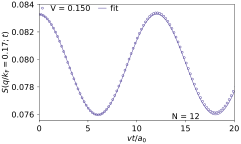

In [14]:
plt.style.reload_library()
with plt.style.context('./include/sans.mplstyle'):

    fig, axes = plt.subplots(1,1,sharex=False, sharey=False, squeeze=True)
    cVf = 0.15
    cN = 12
    q_index = 1

    key = quench.lookup(cN,Vi,cVf,Δt,cn)
    K = quench.KV(cVf)
    
    # S(q;t) for a single value of V
    
    # get the time dependent S(q,t) data 
    data = S̄[key][:,q_index]
    t = g2[key][:,0]*quench.tscalefactor(cVf)

    props = {'mec':colors[-1],'mew':0.5, 'ls':'None','ms':2, 'mfc':'None'}
    flabel = r'fit: $1 + 2n_{\rm LL} + \sinh(2\beta)\cos(2\omega_q t)$'
    SLL = K*np.abs(q[key])/(2.0*kF)
    axes.plot(t,data*SLL[q_index], 'o', **props, label=f'V = {cVf:5.3f}')
    axes.plot(t,S̄LL(Sfit[key].params,t)*SLL[q_index],'-', color=colors[-1], linewidth=0.5, label=r'fit', zorder=-10)
    axes.set_xlabel(r'$vt/a_0$')
    axes.set_ylabel(r'$S(q/k_{{\rm F}}={:.2f};t)$'.format(q[key][q_index]/kF))
    axes.text(0.68,0.01,f'N = {cN}',transform=axes.transAxes, fontsize=8, ha='left')

    axes.set_xlim(0,20)
    axes.legend(frameon=False, loc=(-0.02,0.9), handletextpad=0.5, handlelength=1.0, ncol=2, columnspacing=1.0)
    
    # Store everything so we can plot it in another notebook
    structure = {'x1':t,'y1':data*SLL[q_index],'x2':t,'y2':S̄LL(Sfit[key].params,t)*SLL[q_index],'q':q, 'kF':kF}
    
    with open('../figures/Sq_boson_fit.pickle', 'wb') as pfile:
        pickle.dump(structure, pfile, pickle.HIGHEST_PROTOCOL)
    
    #plt.savefig(f'../figures/SqnLL_N{cN}.pdf')